In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Plot_tools import *

from scipy.ndimage import label, generate_binary_structure, binary_dilation

plevels = np.asarray([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,  82500.,
                       80000.,  77500.,  75000.,  72500.,  70000.,  67500.,  65000.,  62500.,
                       60000.,  57500.,  55000.,  52500.,  50000.,  47500.,  45000.,  42500.,
                       40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,  22500.,
                       20000.,  17500.,  15000.,  12500.,  10000.,   7000.,   5000.,   3000.,
                        2000.,   1000.,    700.,    500.,    200.])

_nthreads = 2

#---------------------------------------------------------------------
def interp3dz_np(data, z3d, z1d, nthreads = _nthreads):
    
    dinterp = np.zeros((len(z1d),data.shape[1]),dtype=np.float32)

    if nthreads < 0:  # turning this off for now.
        def worker(j):
            print("running %d %s" % (i, data.shape))
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        pool = mp.Pool(nthreads)
        for i in np.arange(data.shape[2]):
            pool.apply_async(worker, args = (i, ))
        pool.close()
        pool.join()
        
        return dinterp
    
    else:        
        for j in np.arange(data.shape[1]):
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        return dinterp



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
def generate_real_profiles(run_dir, model_type='wrf', w_thresh = 5.0, cref_thresh = 45., min_pix=5):
    
    # Helper functions......

    def add_fhour(ds):

        filename = ds.encoding["source"].split("_")

        init_time = int(filename[-2])
        fhour     = int(filename[-1][-5:-3])

        ds.coords['fhour'] = fhour
        ds.coords['init_time'] = init_time

        return ds

    def open_mfdataset_list(data_dir, pattern):
        """
        Use xarray.open_mfdataset to read multiple netcdf files from a list.
        """
        filelist = os.path.join(data_dir,pattern)
        return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

    if model_type == 'wrf':
        
        ds   = open_mfdataset_list(run_dir,  "econus_*")

        w    = ds.W.values
        dbz  = ds.REFL_10CM.values
        pres = np.broadcast_to(ds.pres.values[np.newaxis, :, np.newaxis, np.newaxis], w.shape)
        z    = ds.GPH.values/9.806 

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
        
        ds.close()

        return profiles
    
    if model_type == 'fv3':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,  "econus_*")

        w    = ds.W.values
        dbz  = ds.REFL_10CM.values
        pres = np.broadcast_to(100*ds.pres.values[np.newaxis, :, np.newaxis, np.newaxis], w.shape) 
        z    = ds.GPH.values/9.806 

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
        
        ds.close()

        return profiles
    
#-------------------------------------------------------------------------------
def compute_obj_profiles(W, DBZ, PRES, Z, w_thresh = 5.0, cref_thresh = 45., min_pix=5):
           
    cref = DBZ.max(axis=1)
        
    mask_cref = np.where(cref >= cref_thresh, 1, 0)
    
    mask_p = np.where(PRES <= 70000., 1, 0)
    
    print('P', np.sum(mask_p))
    
    mask_w = np.where(W > w_thresh, 1, 0)
    
    mask_w_p = np.where( mask_p + mask_w == 2, 1, 0)
    
    mask_w_p_2d = np.where(mask_w_p.max(axis=1) + mask_cref == 2, 1, 0)

    f_mask = np.array(np.where(mask_w_p_2d == 1, 1, 0), dtype=np.int8)
        
    # this next block of code looks for a 3x3 connected region of True (1) values.
    
    connectivity = np.ones((3,) * 2)  # 3x3 matric of ones

    wlist   = [] 
    all_obj = 0
    w_obj   = 0
    
    for n in np.arange(W.shape[0]): # loop over number of time steps.
        
        # check to see if there are objects
        
        if (np.sum(f_mask[n]) == 0):
            
            continue

        else:
        
            labeled_array = label(f_mask[n], connectivity)[0]        # returns a 2D array of labels for updrafts)

            num_obj = np.unique(labeled_array)                       # find the number of unique objects (background will be one obj)

            all_obj += (num_obj.shape[0]-1)

            if( num_obj.shape[0] > 1 ):                              # if there is more than the background object, process array.

                for l in num_obj[1:]:                                # this is just a list of 1,2,3,4.....23,24,25....
                    npix = np.sum(labeled_array == l)                # this is a size check - number of pixels assocated with a label
                    if npix >= min_pix:
                        jloc, iloc = np.where(labeled_array == l)    # extract out the locations of the updrafts 
                        w_obj += 1
                        if len(iloc) > 0:
                            wraw = W[n,:,jloc,iloc]               # get w_raw profiles
                            
                            wlist.append([wraw.transpose().mean(axis=1)],)
                            
    if( len(wlist) < 1 ):
        
        print("\n ---> Compute_Obj_Profiles found no objects...returning zero...\n")
        return np.zeros((zhgts.shape[0],1))
    
    else:
        
        wprofile = np.squeeze(np.asarray(wlist), axis=1).transpose()

        print("\n Number of selected updraft profiles:  %d \n Number of labeled objects:  %d\n" % (w_obj, all_obj))
    
        return np.sort(wprofile, axis=1)

In [78]:
w_thresh    = 5.0
cref_thresh = 45.
min_pix     = 3

# WRF #######

input_dir  = '/work/larissa.reames/2020081006/hrrr'
output_dir = './'

wrf_profile = generate_real_profiles(input_dir, model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)

# print(wrf_profile.shape)
# for n in np.arange(wrf_profile.shape[1]):
#     print(n, wrf_profile[:,n].max())

# FV3 #######

input_dir  = '/work/larissa.reames/2020081006/nord3'
output_dir = './'

fv3_profile = generate_real_profiles(input_dir, model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)


P 219313710

 Number of selected updraft profiles:  622 
 Number of labeled objects:  1169

P 214186896

 Number of selected updraft profiles:  708 
 Number of labeled objects:  896



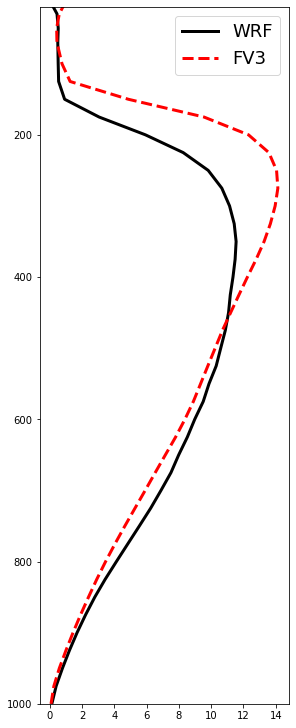

In [82]:
percentile = 0.90


fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(4,10))

idx = int(wrf_profile.shape[1] * percentile)

# for n in np.arange(idx,wrf_profile.shape[1]):
#     print(n, wrf_profile[:,n].max())

idx = int(wrf_profile.shape[1] * percentile)
ax.plot(wrf_profile[:,idx:].mean(axis=1), plevels/100., color='k', linewidth=3., label='WRF')

idx = int(fv3_profile.shape[1] * percentile)
ax.plot(fv3_profile[:,idx:].mean(axis=1), plevels/100., color='r', linewidth=3., linestyle='--', label='FV3')

#ax.plot(fv3_wprofile.mean(axis=1), zhgts, color='r', linewidth=3., linestyle='--', label='FV3_Q14')

ax.invert_yaxis()
ax.set_ylim(1000., 20.)
ax.legend(fontsize=18)
plt.show()